In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterCorr_copy import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from typing import Dict, Optional, List, Any
from numdifftools import Hessian

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


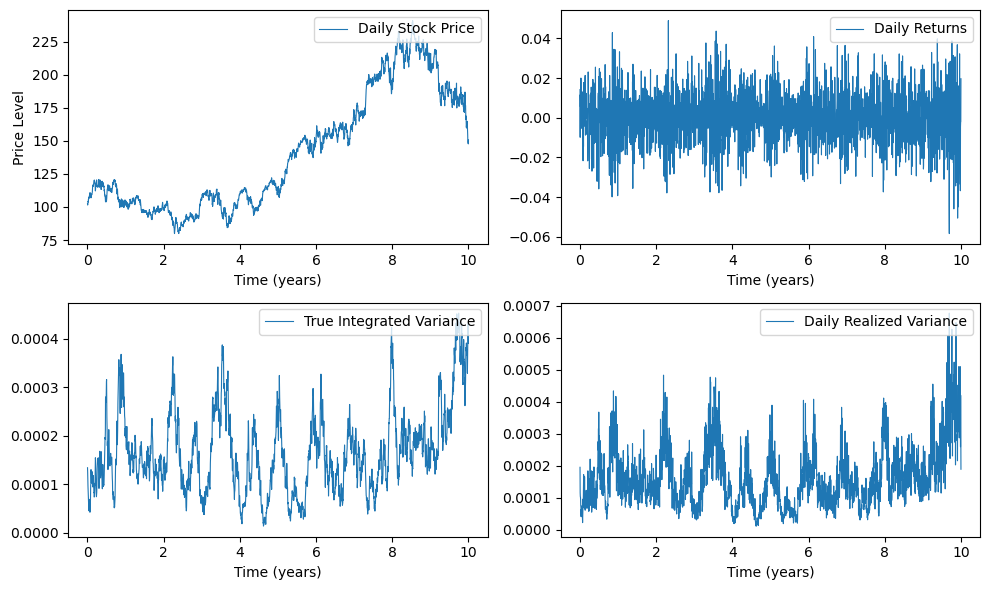

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [6]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.02, 0.00015, 0.001, 0.001, 0.001, -0.4]) # kappa, theta, xi, mu, sigma, rho

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40907D+04    |proj g|=  5.90000D-01

At iterate    1    f= -1.40952D+04    |proj g|=  5.87365D-01

At iterate    2    f= -1.40974D+04    |proj g|=  4.67969D+03

At iterate    3    f= -1.40974D+04    |proj g|=  1.09708D+03

At iterate    4    f= -1.40978D+04    |proj g|=  5.88546D-01

At iterate    5    f= -1.40997D+04    |proj g|=  6.78508D+03

At iterate    6    f= -1.41017D+04    |proj g|=  1.09063D+04

At iterate    7    f= -1.41035D+04    |proj g|=  3.66927D+03

At iterate    8    f= -1.41036D+04    |proj g|=  1.51745D+04

At iterate    9    f= -1.41038D+04    |proj g|=  2.19530D+03

At iterate   10    f= -1.41038D+04    |proj g|=  4.41461D+02

At iterate   11    f= -1.41038D+04    |proj g|=  1.07721D+00

At iterate   12    f= -1.41038D+04    |proj g|=  2.24176D+02

At iterate   13    f= -1.4

### Return - Corr

In [7]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.5]) # kappa, theta, xi, mu, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.80155D+03    |proj g|=  2.27378D+04

At iterate    1    f= -3.80750D+03    |proj g|=  8.12281D+03

At iterate    2    f= -3.80817D+03    |proj g|=  1.92212D+03

At iterate    3    f= -3.80818D+03    |proj g|=  1.95178D+03

At iterate    4    f= -3.80818D+03    |proj g|=  1.96796D+03

At iterate    5    f= -3.80844D+03    |proj g|=  1.89912D+03

At iterate    6    f= -3.80905D+03    |proj g|=  1.89839D+04

At iterate    7    f= -3.80908D+03    |proj g|=  1.60806D+03

At iterate    8    f= -3.80916D+03    |proj g|=  1.53183D+03

At iterate    9    f= -3.80932D+03    |proj g|=  1.40117D+03

At iterate   10    f= -3.80968D+03    |proj g|=  2.74501D+03

At iterate   11    f= -3.81029D+03    |proj g|=  4.13636D+03

At iterate   12    f= -3.81103D+03    |proj g|=  4.76009D+03

At iterate   13    f= -3.8

### PF

In [8]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 609.1989861433447
resampling since: 1583.7702889995314
resampling since: 4489.732057487852
resampling since: 2508.938993334179
resampling since: 1200.6690043406786
resampling since: 1684.9228517920112
resampling since: 5099.408923531529
resampling since: 5477.729684497965
resampling since: 6403.4667086536465
resampling since: 6173.93943695686
resampling since: 1286.892121545683
resampling since: 3328.6262081726322
resampling since: 4925.718265602068
resampling since: 2071.0230702224912
resampling since: 1222.6569035606142
resampling since: 6277.918987391175
resampling since: 3880.827970255045
resampling since: 2044.9497417088235
resampling since: 4428.6695428300045
resampling since: 547.393022900345
resampling since: 2380.180384790893
resampling since: 5213.2966827035925
resampling since: 2636.4727012199896
resampling since: 3301.4526849450904
resampling since: 2229.6788859202325
resampling since: 1759.5561401345692
resampling since: 1128.7552295211565
resampling sinc

In [9]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 6278.605950849678
resampling since: 6217.843752750149
resampling since: 6697.178825596562
resampling since: 6064.905820261787
resampling since: 5380.876784300306
resampling since: 6364.93901641965
resampling since: 6329.102008301996
resampling since: 6896.249724558621
resampling since: 6505.642527666781
resampling since: 6411.618491094721
resampling since: 6811.238851890712
resampling since: 4369.308944910544
resampling since: 6465.948597626615
resampling since: 6812.525673284857
resampling since: 6961.052867703499
resampling since: 6455.581019273436
resampling since: 6452.301376824207
resampling since: 3067.458833958355
resampling since: 5204.195796981221
resampling since: 6698.625014337535
resampling since: 6926.893946054901
resampling since: 3220.439406937557
resampling since: 6645.679679583905
resampling since: 6736.622155484399
resampling since: 6867.5660879889465
resampling since: 6988.814957964859
resampling since: 4852.474685028999
resampling since: 5971.11023

In [10]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [11]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

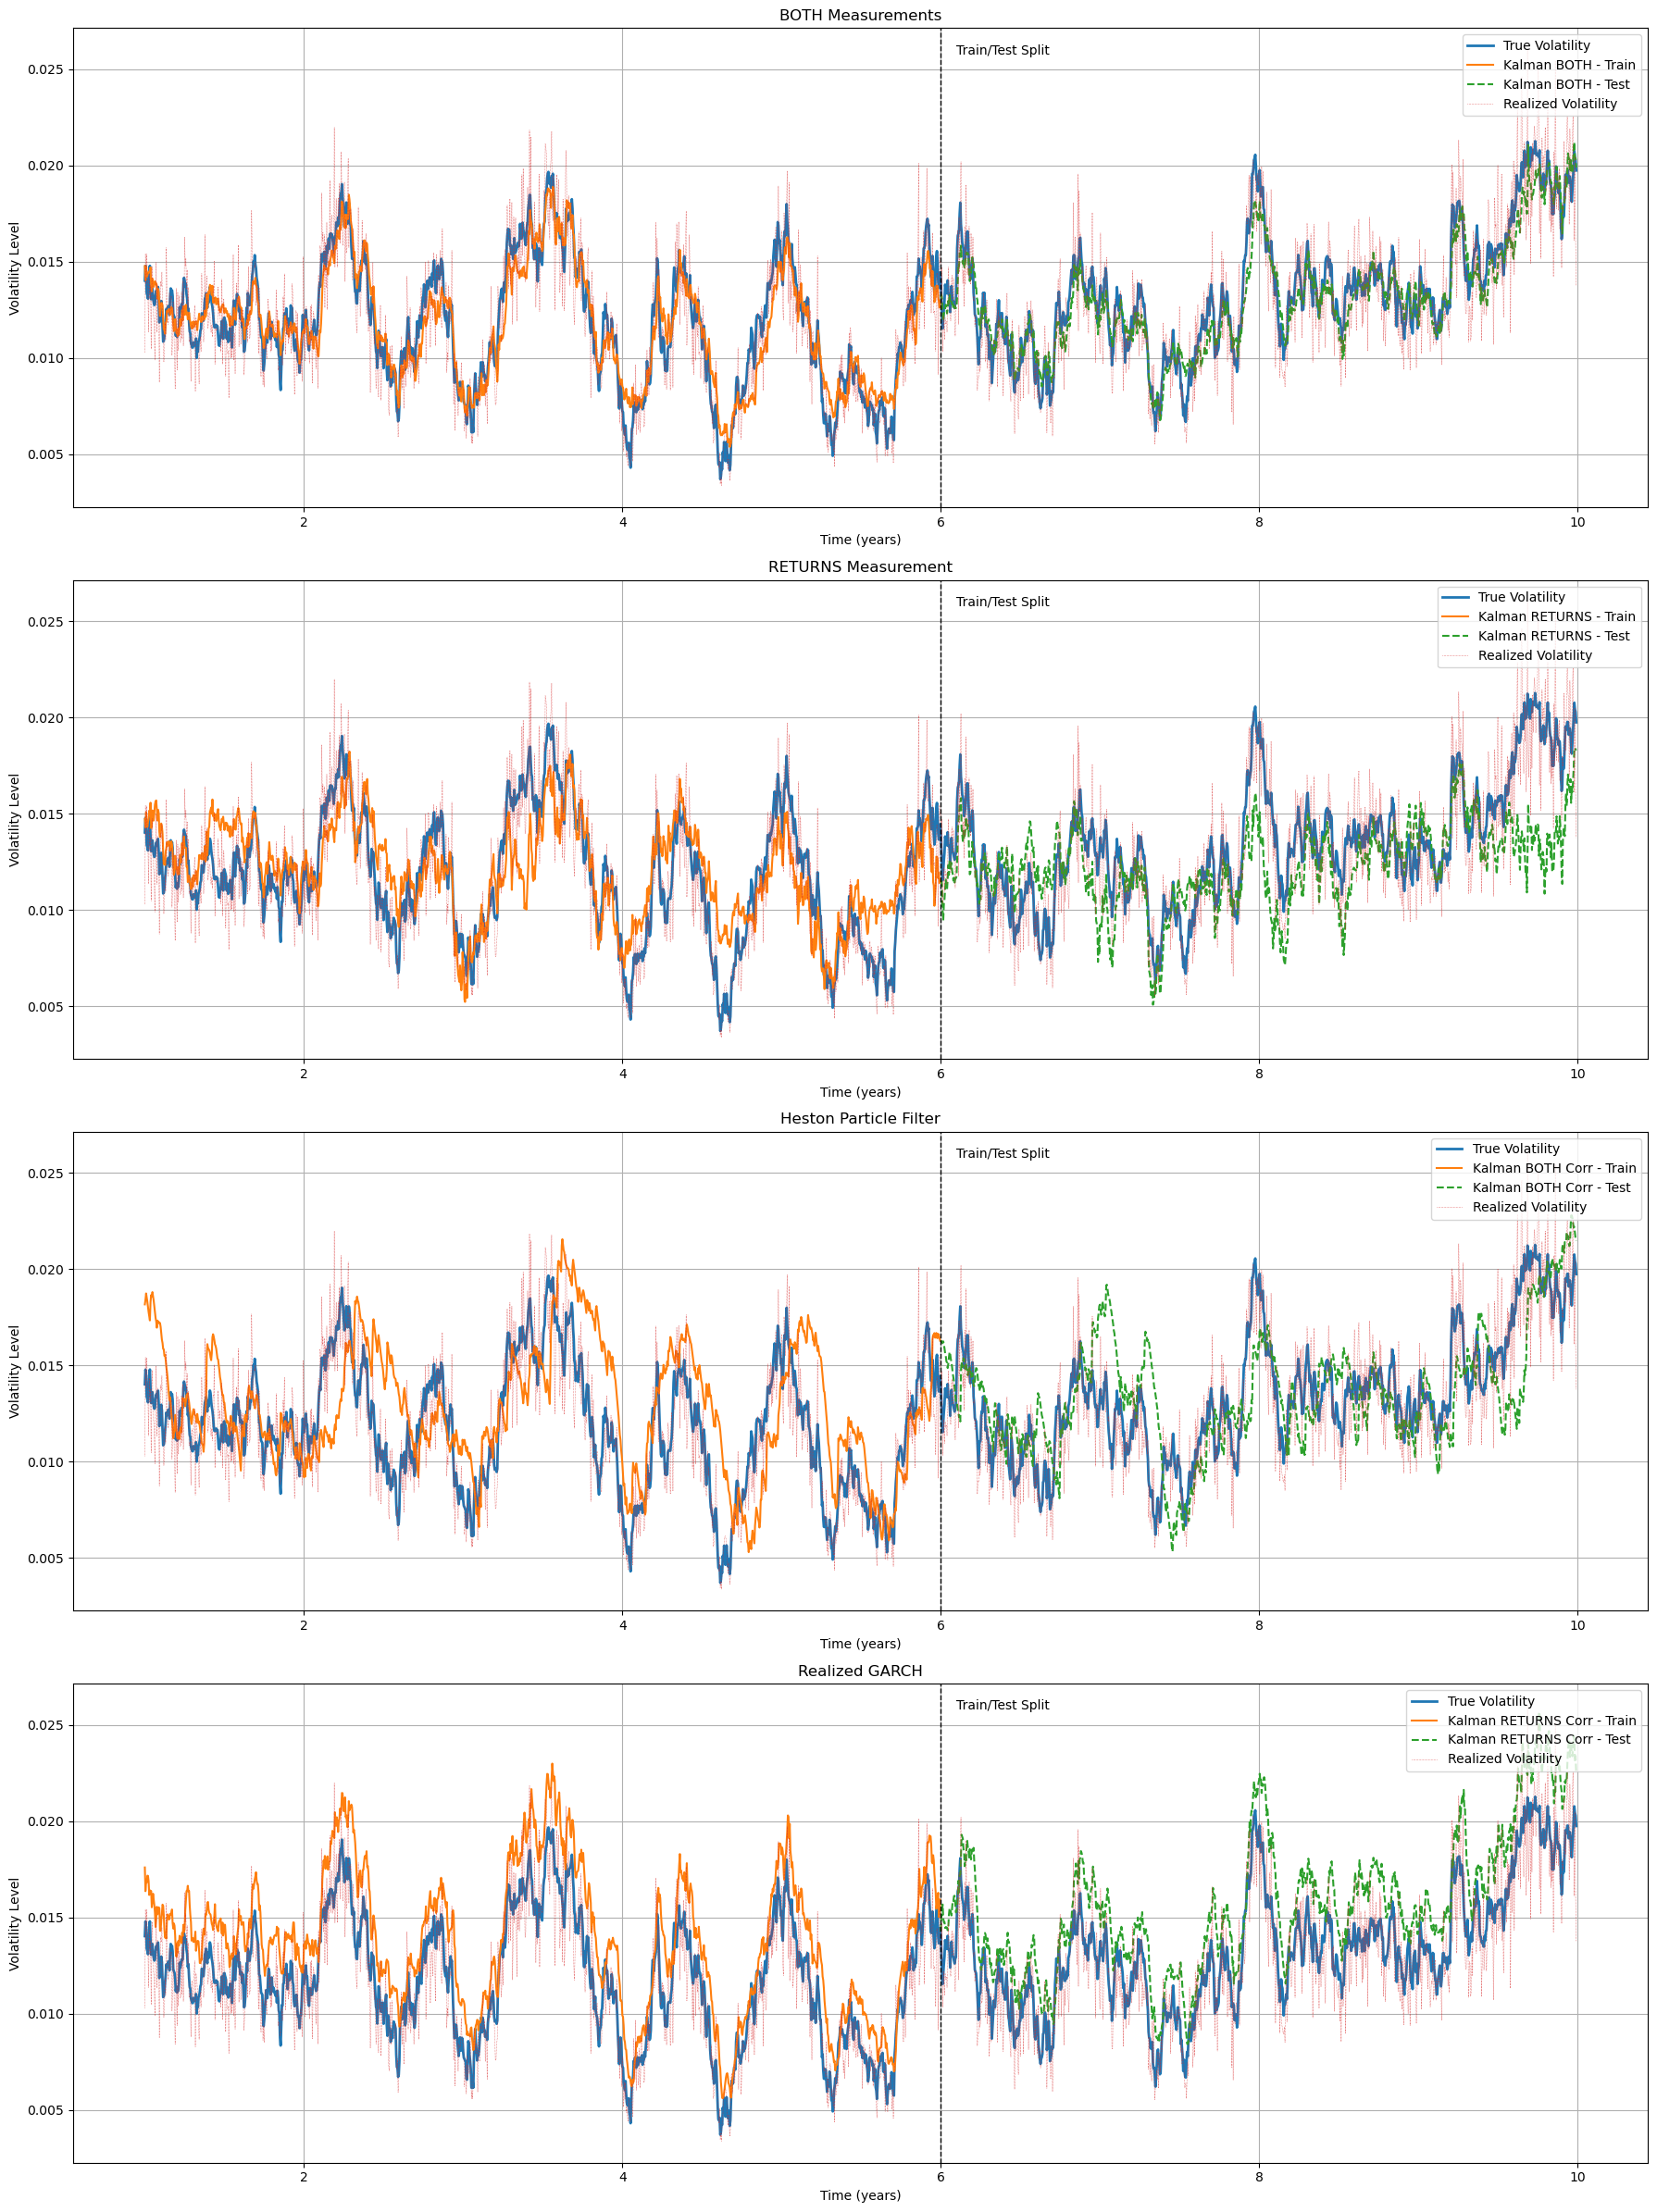

In [12]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)

In [13]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001045, QLIKE: 0.013303
QLKF               RMSE: 0.002643, QLIKE: 0.094195
PF                 RMSE: 0.002641, QLIKE: 0.085498
Realized GARCH     RMSE: 0.002643, QLIKE: 0.057609


In [14]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,3.379267,6.298005,1.291022
theta,0.034150,0.036821,0.027551
xi,0.185432,0.527847,0.280506
mu,0.106741,0.095241,0.041478
sigma,0.000252,NaN,NaN
rho,-0.990000,-0.499993,-0.228878


In [19]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 4))))

omega      0.0093
beta       0.7827
gamma      0.2087
xi        -0.5017
phi        0.9350
tau_1      0.0742
tau_2      0.0048
sigma_u    0.2413
dtype: float64

In [20]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 1230.00model/s]


In [21]:
mcs_mse_results_90

,pvalues,status
models,,
4,0.0000,excluded
3,0.0001,excluded
2,0.0030,excluded
1,1.0000,included


In [22]:
mcs_qlike_results_90

,pvalues,status
models,,
3,0.0,excluded
2,0.0,excluded
4,0.0,excluded
1,1.0,included


In [23]:
mcs_mse_results_75

,pvalues,status
models,,
4,0.0000,excluded
3,0.0000,excluded
2,0.0029,excluded
1,1.0000,included


In [24]:
mcs_qlike_results_75

,pvalues,status
models,,
3,0.0,excluded
2,0.0,excluded
4,0.0,excluded
1,1.0,included
